In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
dir = "/content/drive/MyDrive/ravdess_tess/"
dir

'/content/drive/MyDrive/ravdess_tess/'

In [ ]:
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64,64)),

    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

# Use ImageFolder to create dataset(s)
from torchvision import datasets
data = datasets.ImageFolder(root=dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None)

#test_data = datasets.ImageFolder(root=test_dir,transform=data_transform)

In [ ]:
import os
from torch.utils.data import DataLoader,random_split, Subset


train_dataset, test_dataset = random_split(data,[0.85,0.15])

trainLoader = DataLoader(train_dataset, batch_size=32, shuffle=True,drop_last=True)
testLoader = DataLoader(test_dataset, batch_size=32, drop_last=True)


In [ ]:
class CNNLSTM(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.lstm1 = nn.LSTM(hidden_units*16*4, 200, batch_first=True)
        self.lstm2 = nn.LSTM(200, 100, batch_first=True)
        self.classifier = nn.Linear(hidden_units*10 , output_shape)


    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = x.view(x.size(0), -1)  # Flattening
        x = x.unsqueeze(1)
        _, (x, _) = self.lstm1(x)
        x = x.squeeze(0)
        x = x.unsqueeze(1)
        _, (x, _) = self.lstm2(x)
        x = x.squeeze(0)
        x = self.classifier(x)
        return x



torch.manual_seed(42)
model = CNNLSTM(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                 output_shape=len(data.classes))#.to(device)

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 60):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import torch.nn.functional as F
# Set number of epochs
NUM_EPOCHS = 60

# Recreate an instance of TinyVGG
model = CNNLSTM(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)


# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_results = train(model=model,
                        train_dataloader=trainLoader,
                        test_dataloader=testLoader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9464 | train_acc: 0.1467 | test_loss: 1.9508 | test_acc: 0.1372
Epoch: 2 | train_loss: 1.9434 | train_acc: 0.1437 | test_loss: 1.9442 | test_acc: 0.1406
Epoch: 3 | train_loss: 1.5933 | train_acc: 0.3399 | test_loss: 1.1648 | test_acc: 0.5278
Epoch: 4 | train_loss: 1.0362 | train_acc: 0.5955 | test_loss: 0.8765 | test_acc: 0.6840
Epoch: 5 | train_loss: 0.8343 | train_acc: 0.6810 | test_loss: 0.8305 | test_acc: 0.6892
Epoch: 6 | train_loss: 0.7475 | train_acc: 0.7027 | test_loss: 0.7131 | test_acc: 0.7153
Epoch: 7 | train_loss: 0.6612 | train_acc: 0.7369 | test_loss: 0.6549 | test_acc: 0.7240
Epoch: 8 | train_loss: 0.6189 | train_acc: 0.7539 | test_loss: 0.6221 | test_acc: 0.7569
Epoch: 9 | train_loss: 0.6093 | train_acc: 0.7580 | test_loss: 0.6105 | test_acc: 0.7587
Epoch: 10 | train_loss: 0.5699 | train_acc: 0.7750 | test_loss: 0.5868 | test_acc: 0.7656
Epoch: 11 | train_loss: 0.5430 | train_acc: 0.7777 | test_loss: 0.5736 | test_acc: 0.7778
Epoch: 12 | train_l

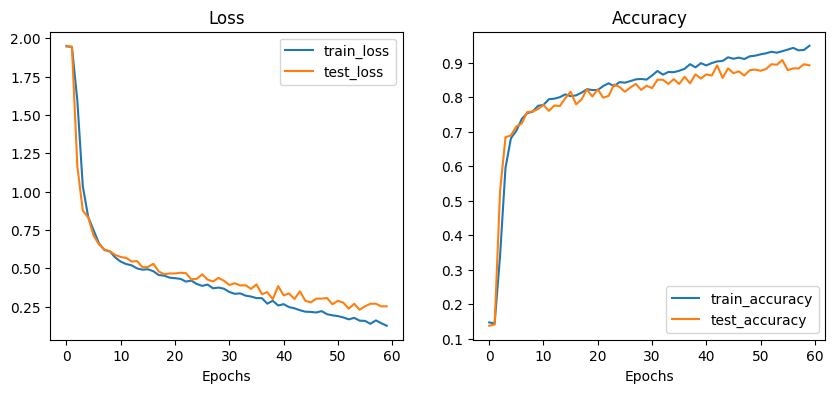

In [ ]:
model_results.keys()

def plot_loss_curves(results: dict()):

    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

plot_loss_curves(model_results)

In [ ]:

# Test the model
model.eval()
test_loss = 0.0
test_accuracy = 0.0
predictions = []
targets = []
test_losses = []
test_accuracies = []

with torch.no_grad():
    for inputs, labels in testLoader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        test_accuracy += (predicted == labels).sum().item()
        test_loss += loss.item()
        predictions.extend(predicted.cpu().numpy())
        targets.extend(labels.cpu().numpy())

    test_accuracy /= len(testLoader.dataset)
    test_loss /= len(testLoader)

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

overall_test_accuracy = (torch.tensor(predictions) == torch.tensor(targets)).sum().item() / len(targets)

print(f"Overall Test Loss: {test_loss:.4f}, Overall Test Accuracy: {overall_test_accuracy:.4f}")

Overall Test Loss: 0.2516, Overall Test Accuracy: 0.8924


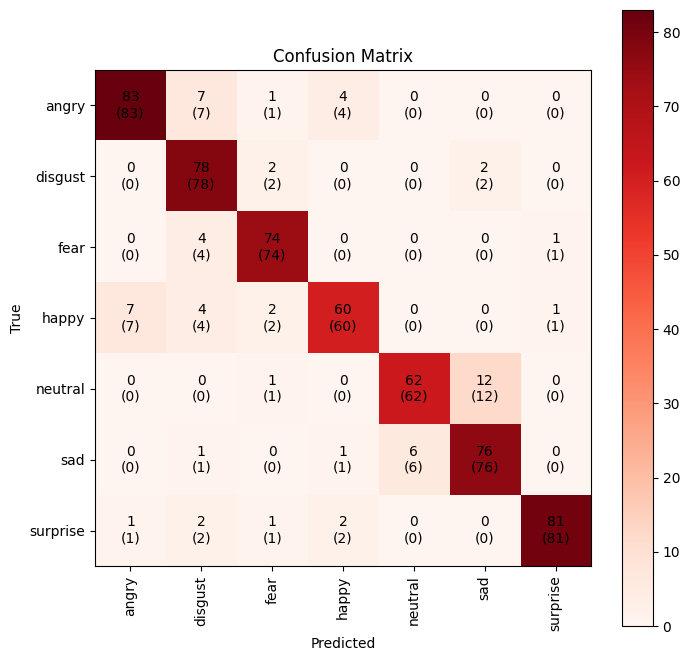

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Compute the confusion matrix and correctly predicted counts
model.eval()
test_predictions = []
test_targets = []
correct_counts = np.zeros((len(data.classes), len(data.classes)), dtype=int)

with torch.no_grad():
    for images, labels in testLoader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        test_predictions.extend(predicted.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

        for pred, target in zip(predicted, labels):
            correct_counts[target.item(), pred.item()] += 1

confusion_mat = confusion_matrix(test_targets, test_predictions)

# Visualize the confusion matrix with correct counts
plt.figure(figsize=(8, 8))
plt.imshow(confusion_mat, cmap='Reds')

# Add correct counts to each cell
for i in range(len(data.classes)):
    for j in range(len(data.classes)):
        plt.text(j, i, f"{confusion_mat[i, j]}\n({correct_counts[i, j]})", ha='center', va='center', color='black')

plt.colorbar()
plt.xticks(np.arange(len(data.classes)), data.classes, rotation=90)
plt.yticks(np.arange(len(data.classes)), data.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Calculate the classification report
report = classification_report(test_targets, test_predictions, target_names=data.classes)

# Print the classification report
print(report)

              precision    recall  f1-score   support

       angry       0.91      0.87      0.89        95
     disgust       0.81      0.95      0.88        82
        fear       0.91      0.94      0.92        79
       happy       0.90      0.81      0.85        74
     neutral       0.91      0.83      0.87        75
         sad       0.84      0.90      0.87        84
    surprise       0.98      0.93      0.95        87

    accuracy                           0.89       576
   macro avg       0.90      0.89      0.89       576
weighted avg       0.90      0.89      0.89       576



In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model_cnn_lstm1.pth')

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

In [ ]:
pip install pydub

In [ ]:
import soundfile
from soundfile import SoundFile
from pydub import AudioSegment

torch.Size([1, 3, 64, 64])
fear


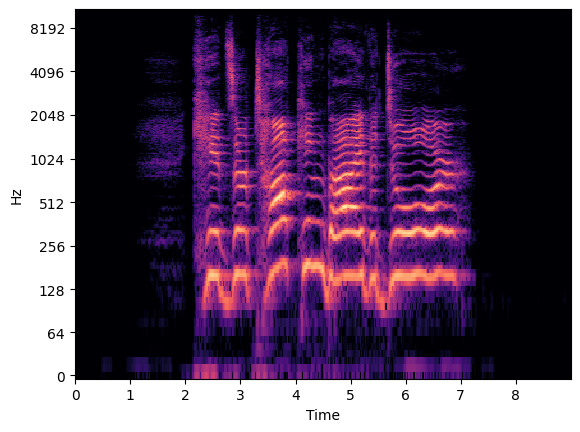

In [ ]:
file_path='/content/drive/MyDrive/fear_test4.wav'
sound = AudioSegment.from_wav(file_path)
sound = sound.set_channels(1)
sound.export(file_path, format="wav")

with SoundFile(file_path) as audio1:

    waveform=audio1.read(dtype="float32")


    sample_rate=audio1.samplerate
                    #final_waveform=pitch(shift_waveform,sample_rate)

    librosa.display.waveshow(waveform,sr=sample_rate)
    stft_spectrum_matrix = librosa.stft(waveform)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
    plt.savefig('/content/drive/MyDrive/test_spectrogram/angry/fear_spec.png')


input_testing = datasets.ImageFolder(root='/content/drive/MyDrive/test_spectrogram', # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None)
#model.eval()

model=CNNLSTM(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(data.classes)).to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/model_cnn_lstm1.pth'))
for batch,(X, y) in enumerate(input_testing):
    X=X.unsqueeze(0)
    X=X.to(device)
    print(X.shape)
    with torch.no_grad():
        y_pred = model(X).to(device)
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)



class_labels = data.classes  # Assuming 'data.classes' contains the class labels used during training
predicted_label = class_labels[y_pred_class.item()]
print(predicted_label)